# Kalman Filter
##### Sean Wade

A Kalman filter is an algorithm that takes a sequence of noisy observations made over time and attempts to get rid of the noise, producing more accurate estimates than the original observations.

In [1]:
from __future__ import division, print_function
import numpy as np
from numpy.random import multivariate_normal

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://seanwade.com/jupyter.css').read())

## Problem 1

In [107]:
class KalmanFilter(object):
    
    def __init__(self, F, Q, H, R, u):
        """
        Initialize the dynamical system models.
        Parameters
        ----------
        F : ndarray of shape (n,n)
            The state transition model.
        Q : ndarray of shape (n,n)
            The covariance matrix for the state noise.
        H : ndarray of shape (m,n)
            The observation model.
        R : ndarray of shape (m,m)
            The covariance matric for observation noise.
        u : ndarray of shape (n,)
            The control vector.
        """
        self.F = F
        self.H = H
        self.B = np.eye(len(u))
        self.H = H
        self.u = u
        self.delta_mu = 0
        self.delta_cov = R
        self.eps_mu = 0
        self.eps_cov = Q 
        
    def evolve(self, x0, N):
        """
        Compute the first N states and observations generated by the Kalman - system.
        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state.
        N : integer
            The number of time steps to evolve.
        Returns
        -------
        states : ndarray of shape (n,N)
            States 0 through N-1, given by each column.
        obs : ndarray of shape (m,N)
            Observations 0 through N-1, given by each column.
        """
        m, n = self.H.shape
        eps_cov = self.eps_cov
        delta_cov = self.delta_cov

        states = np.zeros((N,n))
        states[0] = x0
        
        obs = np.zeros((N,m))
        obs[0] = x0[:m]
        
        for i in range(N-1):
            eps = multivariate_normal(np.zeros(eps_cov.shape[0]), eps_cov)
            delt = multivariate_normal(np.zeros(delta_cov.shape[0]), delta_cov)
            
            states[i+1] = np.dot(self.F, states[i]) + np.dot(self.B, self.u) + eps
            obs[i+1] = np.dot(self.H, states[i]) + delt
            
        return states, obs

     
    def estimate(self, x, P, z):
        """
        Compute the state estimates using the Kalman filter.
        If x and P correspond to time step k, then z is a sequence of
        observations starting at time step k+1.
        Parameters
        ----------
        x : ndarray of shape (n,)
            The initial state estimate.
        P : ndarray of shape (n,n)
            The initial error covariance matrix.
        z : ndarray of shape(m,N)
            Sequence of N observations (each column is an observation).
        Returns
        -------
        out : ndarray of shape (n,N)
            Sequence of state estimates (each column is an estimate).
        """
        m, n = self.H.shape
        N = z.shape[0]
        
        out = np.zeros((N,n))
        out[0] = x
        
        for i in xrange(N-1):
            # Predict Stage
            out[i+1] = np.dot(self.F, out[i]) + self.u
            P = np.dot(self.F, P).dot(self.F.T) + self.eps_cov
            
            # Update Stage
            y = z[i+1] - np.dot(self.H, out[i+1])
            S = np.dot(self.H, P).dot(self.H.T) + self.delta_cov
            K = np.dot(P, self.H.T).dot(np.linalg.inv(S))
            out[i+1] = out[i+1] + np.dot(K, y)
            P = (np.eye(P.shape[0]) - K.dot(self.H)).dot(P)
        return out
    
    def predict(self, x, k):
        """
        Predict the next k states in the absence of observations.

        Parameters
        ----------
        x : ndarray of shape (n,)
            The current state estimate.
        k : integer
            The number of states to predict.

        Returns
        -------
        out : ndarray of shape (n,k)
        The next k predicted states.
        """
        n = len(x)
        out = np.zeros((k,n))
        out[0] = x
        
        for i in range(k-1):
            out[i+1] = np.dot(self.F, out[i]) + self.u
            
        return out
    
    def rewind(self, x, k):
        """
        Predict the k states preceding the current state estimate x.
        Parameters
        ----------
        x : ndarray of shape (n,)
            The current state estimate.
        k : integer
            The number of preceding states to predict.
        Returns
        -------
        out : ndarray of shape (n,k)
        The k preceding predicted states.
        """
        n = len(x)
        out = np.zeros((k,n))
        out[0] = x
                
        for i in xrange(k-1):
            out[i+1] = np.linalg.inv(self.F).dot(out[i] - self.u)
            
        return out
        
    

## Problem 2

In [108]:
Q = .1 * np.eye(4)
R = 5000 * np.eye(2)
F = np.array([
    [1, 0, .1, 0],
    [0, 1, 0, .1],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])
H = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0]])
u = np.array([0, 0, 0, -.98])
kf = KalmanFilter(F, Q, H, R, u)

## Problem 3

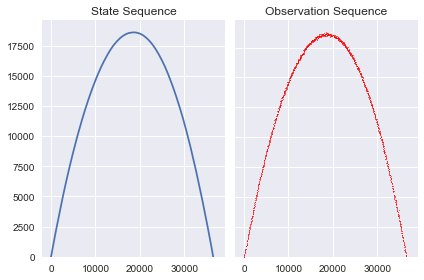

In [109]:
x0 = np.array([0, 0, 300, 600])
states, obs = kf.evolve(x0, 1250)

ax1 = plt.subplot(121)
plt.title('State Sequence')
plt.plot(states[:,0], states[:,1])
plt.ylim(0)

ax2 = plt.subplot(122, sharex=ax1)
plt.title('Observation Sequence')
plt.scatter(obs[:,0], obs[:,1], s=.3, c='r')
plt.setp(ax2.get_yticklabels(), visible=False)
plt.ylim(0)

plt.tight_layout()
plt.show()

## Problem 5

In [110]:
x = states[200]
vel = np.zeros((9,2))
for i in xrange(9):
    vel[i] = obs[201+i] - obs[200+i]
    
x[2:] = np.mean(vel, axis=0)
P = 10**6 * Q
z = obs[200:801]

est = kf.estimate(x, P, z)

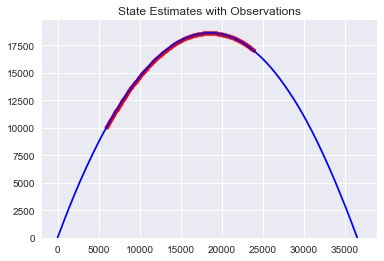

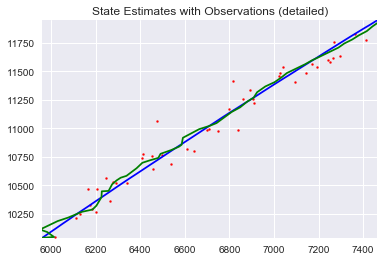

In [111]:
plt.plot(states[:,0], states[:,1], 'b')
plt.scatter(est[:,0], est[:,1], s=10, c='r')
plt.title('State Estimates with Observations')
plt.ylim(0)
plt.show()

plt.plot(states[:,0], states[:,1], 'b')
plt.plot(est[:,0], est[:,1], 'g')
plt.scatter(obs[:,0], obs[:,1], s=4, c='r')
plt.title('State Estimates with Observations (detailed)')
plt.xlim(states[200, 0], states[250, 0])
plt.ylim(states[200, 1], states[250, 1])
plt.show()

## Problem 7

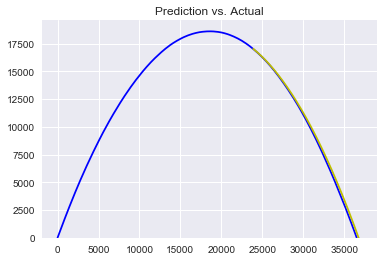

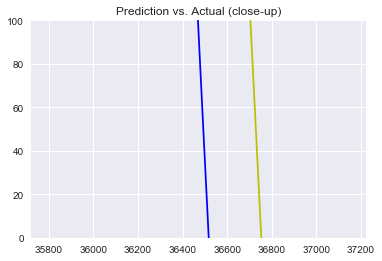

In [112]:
# Get the last estimated state from observations
x = est[-1]
pred = kf.predict(x, 450)

plt.title('Prediction vs. Actual')
plt.plot(states[:,0], states[:,1], 'b')
plt.plot(pred[:,0], pred[:,1], 'y')
plt.ylim(0)
plt.show()

plt.plot(states[:,0], states[:,1], 'b')
plt.plot(pred[:,0], pred[:,1], 'y')
plt.title('Prediction vs. Actual (close-up)')
plt.xlim(states[1220, 0] - 500, states[1220, 0]+1000)
plt.ylim(0, 100)
plt.show()

## Problem 9

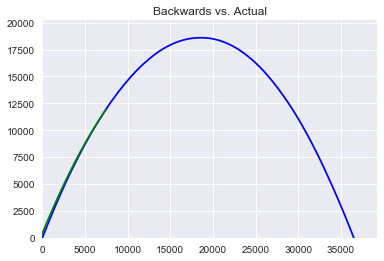

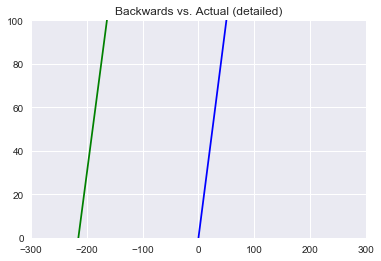

In [113]:
x = est[50]
prev = kf.rewind(x, 450)

plt.plot(states[:,0], states[:,1], 'b')
plt.plot(prev[:,0], prev[:,1], 'g')
plt.title('Backwards vs. Actual')
plt.xlim(0)
plt.ylim(0)
plt.show()

plt.plot(states[:,0], states[:,1], 'b')
plt.plot(prev[:,0], prev[:,1], 'g')
plt.title('Backwards vs. Actual (detailed)')
plt.xlim(-300, 300)
plt.ylim(0, 100)
plt.show()

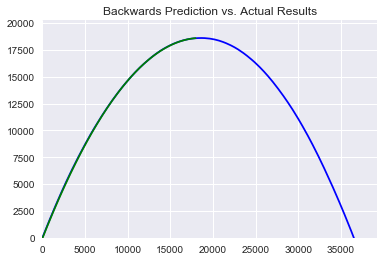

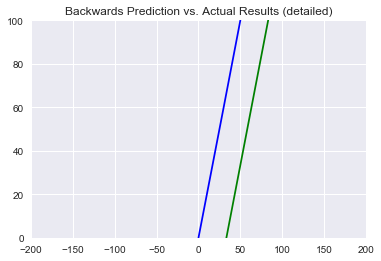

In [114]:
x = est[400]
prev = kf.rewind(x, 800)

plt.plot(states[:,0], states[:,1], 'b')
plt.plot(prev[:,0], prev[:,1], 'g')
plt.title('Backwards Prediction vs. Actual Results')
plt.xlim(0)
plt.ylim(0)
plt.show()

plt.plot(states[:,0], states[:,1], 'b')
plt.plot(prev[:,0], prev[:,1], 'g')
plt.title('Backwards Prediction vs. Actual Results (detailed)')
plt.xlim(-200, 200)
plt.ylim(0, 100)
plt.show()

The second one is better because it has more information.